# Our final model

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.23.4


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.0


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


## Loading and preparing our data set for classification

In [7]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 26800  100 26800    0     0   167k      0 --:--:-- --:--:-- --:--:--  167k


In [8]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
y=df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

In [9]:
df.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [10]:
df.describe()

,speed,age,miles
count,1500.000000,1500.000000,1500.000000
mean,122.492667,44.952667,30.344000
std,17.604333,17.191727,15.463152
min,68.000000,9.000000,-21.000000
25%,108.000000,32.000000,18.000000
50%,120.000000,42.000000,29.000000
75%,137.000000,55.000000,42.000000
max,166.000000,102.000000,84.000000


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [14]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data, xlim=None, ylim=None):
    h = 1  # step size in the mesh
    if xlim == None:
        xlim = x_data.min(), x_data.max()
    if ylim == None:
        ylim = y_data.min(), y_data.max()
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.arange(x_min - 1, x_max + 1, h),
                         np.arange(y_min - 1, y_max + 1, h))
    return xx, yy, xlim, ylim
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False, xlim=(16, 90), ylim=(70, 170)):
    xx,yy, xlim, ylim = meshGrid(x_data, y_data, xlim, ylim)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)
                
def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_

## Almost all real-life scenarios have many more than 2 inputs
* With more than 2 input features plotting decision boundaries does not make much sense any more
* From now on we work with 3 features and only rely on accuracy measures

In [15]:
num_categories = 3
dropout = 0.6
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(100, name='hidden1', input_dim=3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(100, name='hidden2'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(num_categories, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               400       
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
__________

### We also limit the number of epochs further to 2000 (because we have seen that after that nothing good is going to happen)

In [16]:
BATCH_SIZE=1000
EPOCHS = 2000

%time history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/2000
720/720 [==============================] - 1s 1ms/step - loss: 1.6602 - acc: 0.3236 - val_loss: 8.9324 - val_acc: 0.3278
Epoch 2/2000
720/720 [==============================] - 0s 15us/step - loss: 1.7524 - acc: 0.3208 - val_loss: 9.1273 - val_acc: 0.3278
Epoch 3/2000
720/720 [==============================] - 0s 15us/step - loss: 1.6297 - acc: 0.3375 - val_loss: 9.2851 - val_acc: 0.3278
Epoch 4/2000
720/720 [==============================] - 0s 14us/step - loss: 1.5927 - acc: 0.3333 - val_loss: 9.3396 - val_acc: 0.3278
Epoch 5/2000
720/720 [==============================] - 0s 31us/step - loss: 1.5997 - acc: 0.3569 - val_loss: 9.3583 - val_acc: 0.3278
Epoch 6/2000
720/720 [==============================] - 0s 17us/step - loss: 1.4146 - acc: 0.3903 - val_loss: 9.3641 - val_acc: 0.3278
Epoch 7/2000
720/720 [==============================] - 0s 14us/step - loss: 1.4498 - acc: 0.3847 - val_loss: 9.3765 - val_acc: 0.3278
Epoch 8/20

Epoch 61/2000
720/720 [==============================] - 0s 11us/step - loss: 0.9036 - acc: 0.6153 - val_loss: 3.8075 - val_acc: 0.4722
Epoch 62/2000
720/720 [==============================] - 0s 14us/step - loss: 0.9254 - acc: 0.5972 - val_loss: 3.7673 - val_acc: 0.4722
Epoch 63/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8835 - acc: 0.6278 - val_loss: 3.7177 - val_acc: 0.4722
Epoch 64/2000
720/720 [==============================] - 0s 13us/step - loss: 0.8924 - acc: 0.6125 - val_loss: 3.6648 - val_acc: 0.4722
Epoch 65/2000
720/720 [==============================] - 0s 26us/step - loss: 0.9091 - acc: 0.6125 - val_loss: 3.6127 - val_acc: 0.4722
Epoch 66/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8838 - acc: 0.6125 - val_loss: 3.5627 - val_acc: 0.4722
Epoch 67/2000
720/720 [==============================] - 0s 14us/step - loss: 0.8774 - acc: 0.6208 - val_loss: 3.5081 - val_acc: 0.4722
Epoch 68/2000
720/720 [=========================

Epoch 122/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8233 - acc: 0.6472 - val_loss: 1.9020 - val_acc: 0.4944
Epoch 123/2000
720/720 [==============================] - 0s 14us/step - loss: 0.8196 - acc: 0.6611 - val_loss: 1.8815 - val_acc: 0.4889
Epoch 124/2000
720/720 [==============================] - 0s 12us/step - loss: 0.8055 - acc: 0.6819 - val_loss: 1.8640 - val_acc: 0.4833
Epoch 125/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7759 - acc: 0.6944 - val_loss: 1.8464 - val_acc: 0.4722
Epoch 126/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7995 - acc: 0.6875 - val_loss: 1.8288 - val_acc: 0.4667
Epoch 127/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7794 - acc: 0.6847 - val_loss: 1.8115 - val_acc: 0.4722
Epoch 128/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7857 - acc: 0.6722 - val_loss: 1.7968 - val_acc: 0.4778
Epoch 129/2000
720/720 [=================

Epoch 182/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7611 - acc: 0.6806 - val_loss: 1.0452 - val_acc: 0.5944
Epoch 183/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7665 - acc: 0.6889 - val_loss: 1.0387 - val_acc: 0.5944
Epoch 184/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7683 - acc: 0.6764 - val_loss: 1.0331 - val_acc: 0.5944
Epoch 185/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7568 - acc: 0.7000 - val_loss: 1.0278 - val_acc: 0.5944
Epoch 186/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7466 - acc: 0.6861 - val_loss: 1.0219 - val_acc: 0.5889
Epoch 187/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7532 - acc: 0.6847 - val_loss: 1.0137 - val_acc: 0.5944
Epoch 188/2000
720/720 [==============================] - 0s 26us/step - loss: 0.7389 - acc: 0.7111 - val_loss: 1.0050 - val_acc: 0.5944
Epoch 189/2000
720/720 [=================

Epoch 242/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7307 - acc: 0.7125 - val_loss: 0.6992 - val_acc: 0.7278
Epoch 243/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7388 - acc: 0.6847 - val_loss: 0.6951 - val_acc: 0.7278
Epoch 244/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7457 - acc: 0.7153 - val_loss: 0.6911 - val_acc: 0.7333
Epoch 245/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7187 - acc: 0.7097 - val_loss: 0.6877 - val_acc: 0.7333
Epoch 246/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7178 - acc: 0.7056 - val_loss: 0.6845 - val_acc: 0.7333
Epoch 247/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7306 - acc: 0.7056 - val_loss: 0.6819 - val_acc: 0.7333
Epoch 248/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7780 - acc: 0.6875 - val_loss: 0.6795 - val_acc: 0.7389
Epoch 249/2000
720/720 [=================

Epoch 302/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7292 - acc: 0.7153 - val_loss: 0.6102 - val_acc: 0.7833
Epoch 303/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6716 - acc: 0.7500 - val_loss: 0.6084 - val_acc: 0.7889
Epoch 304/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7128 - acc: 0.7125 - val_loss: 0.6071 - val_acc: 0.7889
Epoch 305/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7459 - acc: 0.7000 - val_loss: 0.6057 - val_acc: 0.7889
Epoch 306/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6906 - acc: 0.7222 - val_loss: 0.6048 - val_acc: 0.7889
Epoch 307/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7329 - acc: 0.7181 - val_loss: 0.6042 - val_acc: 0.7833
Epoch 308/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6943 - acc: 0.7208 - val_loss: 0.6037 - val_acc: 0.7944
Epoch 309/2000
720/720 [=================

Epoch 362/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6847 - acc: 0.7194 - val_loss: 0.5703 - val_acc: 0.8111
Epoch 363/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7309 - acc: 0.7042 - val_loss: 0.5699 - val_acc: 0.8111
Epoch 364/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6941 - acc: 0.7139 - val_loss: 0.5698 - val_acc: 0.8167
Epoch 365/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6507 - acc: 0.7472 - val_loss: 0.5696 - val_acc: 0.8167
Epoch 366/2000
720/720 [==============================] - 0s 10us/step - loss: 0.6682 - acc: 0.7222 - val_loss: 0.5694 - val_acc: 0.8111
Epoch 367/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7003 - acc: 0.7292 - val_loss: 0.5692 - val_acc: 0.8111
Epoch 368/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7083 - acc: 0.7361 - val_loss: 0.5691 - val_acc: 0.8111
Epoch 369/2000
720/720 [=================

Epoch 422/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6792 - acc: 0.7403 - val_loss: 0.5588 - val_acc: 0.8000
Epoch 423/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6793 - acc: 0.7444 - val_loss: 0.5583 - val_acc: 0.8056
Epoch 424/2000
720/720 [==============================] - 0s 26us/step - loss: 0.6729 - acc: 0.7347 - val_loss: 0.5581 - val_acc: 0.8056
Epoch 425/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6562 - acc: 0.7486 - val_loss: 0.5583 - val_acc: 0.8056
Epoch 426/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6569 - acc: 0.7528 - val_loss: 0.5585 - val_acc: 0.8056
Epoch 427/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6760 - acc: 0.7236 - val_loss: 0.5586 - val_acc: 0.8056
Epoch 428/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6852 - acc: 0.7403 - val_loss: 0.5587 - val_acc: 0.8111
Epoch 429/2000
720/720 [=================

Epoch 482/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6810 - acc: 0.7250 - val_loss: 0.5525 - val_acc: 0.7778
Epoch 483/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6627 - acc: 0.7542 - val_loss: 0.5519 - val_acc: 0.7778
Epoch 484/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6733 - acc: 0.7417 - val_loss: 0.5516 - val_acc: 0.7778
Epoch 485/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6967 - acc: 0.7222 - val_loss: 0.5515 - val_acc: 0.7889
Epoch 486/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6593 - acc: 0.7347 - val_loss: 0.5517 - val_acc: 0.7944
Epoch 487/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6768 - acc: 0.7153 - val_loss: 0.5518 - val_acc: 0.7833
Epoch 488/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6855 - acc: 0.7292 - val_loss: 0.5520 - val_acc: 0.7778
Epoch 489/2000
720/720 [=================

Epoch 542/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6629 - acc: 0.7347 - val_loss: 0.5470 - val_acc: 0.7778
Epoch 543/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6725 - acc: 0.7472 - val_loss: 0.5468 - val_acc: 0.7778
Epoch 544/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6437 - acc: 0.7319 - val_loss: 0.5464 - val_acc: 0.7778
Epoch 545/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6611 - acc: 0.7486 - val_loss: 0.5464 - val_acc: 0.7778
Epoch 546/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6780 - acc: 0.7292 - val_loss: 0.5468 - val_acc: 0.7778
Epoch 547/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6357 - acc: 0.7458 - val_loss: 0.5471 - val_acc: 0.7722
Epoch 548/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6694 - acc: 0.7389 - val_loss: 0.5475 - val_acc: 0.7722
Epoch 549/2000
720/720 [=================

Epoch 602/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6788 - acc: 0.7222 - val_loss: 0.5401 - val_acc: 0.7833
Epoch 603/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6512 - acc: 0.7319 - val_loss: 0.5403 - val_acc: 0.7833
Epoch 604/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6414 - acc: 0.7500 - val_loss: 0.5406 - val_acc: 0.7833
Epoch 605/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6480 - acc: 0.7417 - val_loss: 0.5412 - val_acc: 0.7833
Epoch 606/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6376 - acc: 0.7639 - val_loss: 0.5416 - val_acc: 0.7833
Epoch 607/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6275 - acc: 0.7542 - val_loss: 0.5419 - val_acc: 0.7889
Epoch 608/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6643 - acc: 0.7431 - val_loss: 0.5423 - val_acc: 0.7889
Epoch 609/2000
720/720 [=================

Epoch 662/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6342 - acc: 0.7333 - val_loss: 0.5465 - val_acc: 0.7667
Epoch 663/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6289 - acc: 0.7347 - val_loss: 0.5464 - val_acc: 0.7722
Epoch 664/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6398 - acc: 0.7583 - val_loss: 0.5465 - val_acc: 0.7722
Epoch 665/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6487 - acc: 0.7500 - val_loss: 0.5465 - val_acc: 0.7722
Epoch 666/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6213 - acc: 0.7528 - val_loss: 0.5463 - val_acc: 0.7722
Epoch 667/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6462 - acc: 0.7597 - val_loss: 0.5462 - val_acc: 0.7722
Epoch 668/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6330 - acc: 0.7542 - val_loss: 0.5463 - val_acc: 0.7722
Epoch 669/2000
720/720 [=================

Epoch 722/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6355 - acc: 0.7556 - val_loss: 0.5347 - val_acc: 0.7778
Epoch 723/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6538 - acc: 0.7486 - val_loss: 0.5349 - val_acc: 0.7833
Epoch 724/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6217 - acc: 0.7681 - val_loss: 0.5351 - val_acc: 0.7833
Epoch 725/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6336 - acc: 0.7583 - val_loss: 0.5358 - val_acc: 0.7889
Epoch 726/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6043 - acc: 0.7833 - val_loss: 0.5370 - val_acc: 0.7889
Epoch 727/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6334 - acc: 0.7542 - val_loss: 0.5384 - val_acc: 0.7778
Epoch 728/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6364 - acc: 0.7528 - val_loss: 0.5400 - val_acc: 0.7778
Epoch 729/2000
720/720 [=================

Epoch 782/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6161 - acc: 0.7556 - val_loss: 0.5300 - val_acc: 0.8000
Epoch 783/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6376 - acc: 0.7472 - val_loss: 0.5307 - val_acc: 0.8000
Epoch 784/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6331 - acc: 0.7514 - val_loss: 0.5311 - val_acc: 0.8000
Epoch 785/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6151 - acc: 0.7583 - val_loss: 0.5318 - val_acc: 0.7944
Epoch 786/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6038 - acc: 0.7597 - val_loss: 0.5322 - val_acc: 0.7944
Epoch 787/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6252 - acc: 0.7444 - val_loss: 0.5328 - val_acc: 0.8000
Epoch 788/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6347 - acc: 0.7528 - val_loss: 0.5333 - val_acc: 0.8000
Epoch 789/2000
720/720 [=================

Epoch 842/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6236 - acc: 0.7708 - val_loss: 0.5268 - val_acc: 0.8111
Epoch 843/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6316 - acc: 0.7583 - val_loss: 0.5260 - val_acc: 0.8111
Epoch 844/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5955 - acc: 0.7681 - val_loss: 0.5254 - val_acc: 0.8111
Epoch 845/2000
720/720 [==============================] - 0s 26us/step - loss: 0.5947 - acc: 0.7750 - val_loss: 0.5251 - val_acc: 0.8111
Epoch 846/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6308 - acc: 0.7583 - val_loss: 0.5247 - val_acc: 0.8111
Epoch 847/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6115 - acc: 0.7639 - val_loss: 0.5243 - val_acc: 0.8111
Epoch 848/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5949 - acc: 0.7778 - val_loss: 0.5244 - val_acc: 0.8111
Epoch 849/2000
720/720 [=================

Epoch 902/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6072 - acc: 0.7611 - val_loss: 0.5272 - val_acc: 0.7944
Epoch 903/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5702 - acc: 0.7806 - val_loss: 0.5275 - val_acc: 0.7944
Epoch 904/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5960 - acc: 0.7500 - val_loss: 0.5277 - val_acc: 0.7944
Epoch 905/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5991 - acc: 0.7903 - val_loss: 0.5279 - val_acc: 0.7889
Epoch 906/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6078 - acc: 0.7542 - val_loss: 0.5289 - val_acc: 0.7833
Epoch 907/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6228 - acc: 0.7722 - val_loss: 0.5304 - val_acc: 0.7833
Epoch 908/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6077 - acc: 0.7597 - val_loss: 0.5312 - val_acc: 0.7833
Epoch 909/2000
720/720 [=================

Epoch 962/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5895 - acc: 0.7667 - val_loss: 0.5248 - val_acc: 0.7889
Epoch 963/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5975 - acc: 0.7681 - val_loss: 0.5255 - val_acc: 0.7889
Epoch 964/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6344 - acc: 0.7542 - val_loss: 0.5261 - val_acc: 0.7889
Epoch 965/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6124 - acc: 0.7611 - val_loss: 0.5268 - val_acc: 0.7778
Epoch 966/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6027 - acc: 0.7722 - val_loss: 0.5273 - val_acc: 0.7778
Epoch 967/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6081 - acc: 0.7625 - val_loss: 0.5279 - val_acc: 0.7778
Epoch 968/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6002 - acc: 0.7722 - val_loss: 0.5288 - val_acc: 0.7778
Epoch 969/2000
720/720 [=================

Epoch 1022/2000
720/720 [==============================] - 0s 10us/step - loss: 0.6057 - acc: 0.7639 - val_loss: 0.5303 - val_acc: 0.7889
Epoch 1023/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6249 - acc: 0.7444 - val_loss: 0.5293 - val_acc: 0.7889
Epoch 1024/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6158 - acc: 0.7639 - val_loss: 0.5286 - val_acc: 0.7889
Epoch 1025/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6172 - acc: 0.7542 - val_loss: 0.5279 - val_acc: 0.7944
Epoch 1026/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5762 - acc: 0.7847 - val_loss: 0.5271 - val_acc: 0.7944
Epoch 1027/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6014 - acc: 0.7722 - val_loss: 0.5261 - val_acc: 0.7944
Epoch 1028/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6023 - acc: 0.7722 - val_loss: 0.5260 - val_acc: 0.7944
Epoch 1029/2000
720/720 [=========

Epoch 1082/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6056 - acc: 0.7639 - val_loss: 0.5362 - val_acc: 0.7778
Epoch 1083/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6049 - acc: 0.7750 - val_loss: 0.5360 - val_acc: 0.7833
Epoch 1084/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5934 - acc: 0.7583 - val_loss: 0.5358 - val_acc: 0.7833
Epoch 1085/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6073 - acc: 0.7667 - val_loss: 0.5360 - val_acc: 0.7833
Epoch 1086/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5813 - acc: 0.7792 - val_loss: 0.5360 - val_acc: 0.7833
Epoch 1087/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6012 - acc: 0.7639 - val_loss: 0.5361 - val_acc: 0.7833
Epoch 1088/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6088 - acc: 0.7819 - val_loss: 0.5360 - val_acc: 0.7833
Epoch 1089/2000
720/720 [=========

Epoch 1142/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5942 - acc: 0.7611 - val_loss: 0.5414 - val_acc: 0.7611
Epoch 1143/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5802 - acc: 0.7611 - val_loss: 0.5418 - val_acc: 0.7611
Epoch 1144/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5928 - acc: 0.7806 - val_loss: 0.5415 - val_acc: 0.7667
Epoch 1145/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5898 - acc: 0.7722 - val_loss: 0.5397 - val_acc: 0.7667
Epoch 1146/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5885 - acc: 0.7778 - val_loss: 0.5389 - val_acc: 0.7722
Epoch 1147/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5982 - acc: 0.7778 - val_loss: 0.5382 - val_acc: 0.7778
Epoch 1148/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6066 - acc: 0.7778 - val_loss: 0.5381 - val_acc: 0.7778
Epoch 1149/2000
720/720 [=========

Epoch 1202/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6179 - acc: 0.7639 - val_loss: 0.5399 - val_acc: 0.7722
Epoch 1203/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5882 - acc: 0.7903 - val_loss: 0.5400 - val_acc: 0.7722
Epoch 1204/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5759 - acc: 0.7861 - val_loss: 0.5396 - val_acc: 0.7722
Epoch 1205/2000
720/720 [==============================] - 0s 28us/step - loss: 0.5802 - acc: 0.7736 - val_loss: 0.5393 - val_acc: 0.7722
Epoch 1206/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5936 - acc: 0.7889 - val_loss: 0.5392 - val_acc: 0.7722
Epoch 1207/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5839 - acc: 0.7778 - val_loss: 0.5388 - val_acc: 0.7722
Epoch 1208/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6179 - acc: 0.7708 - val_loss: 0.5385 - val_acc: 0.7722
Epoch 1209/2000
720/720 [=========

Epoch 1262/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5998 - acc: 0.7833 - val_loss: 0.5362 - val_acc: 0.7722
Epoch 1263/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5880 - acc: 0.7750 - val_loss: 0.5361 - val_acc: 0.7722
Epoch 1264/2000
720/720 [==============================] - 0s 15us/step - loss: 0.6031 - acc: 0.7736 - val_loss: 0.5365 - val_acc: 0.7667
Epoch 1265/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6104 - acc: 0.7667 - val_loss: 0.5369 - val_acc: 0.7667
Epoch 1266/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5699 - acc: 0.7764 - val_loss: 0.5371 - val_acc: 0.7667
Epoch 1267/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5736 - acc: 0.7889 - val_loss: 0.5370 - val_acc: 0.7722
Epoch 1268/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5900 - acc: 0.7972 - val_loss: 0.5370 - val_acc: 0.7722
Epoch 1269/2000
720/720 [=========

Epoch 1322/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5639 - acc: 0.7750 - val_loss: 0.5323 - val_acc: 0.7722
Epoch 1323/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5553 - acc: 0.7903 - val_loss: 0.5325 - val_acc: 0.7667
Epoch 1324/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5817 - acc: 0.7694 - val_loss: 0.5326 - val_acc: 0.7667
Epoch 1325/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5763 - acc: 0.7736 - val_loss: 0.5329 - val_acc: 0.7667
Epoch 1326/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5609 - acc: 0.7833 - val_loss: 0.5332 - val_acc: 0.7722
Epoch 1327/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5748 - acc: 0.7708 - val_loss: 0.5336 - val_acc: 0.7722
Epoch 1328/2000
720/720 [==============================] - 0s 10us/step - loss: 0.5908 - acc: 0.7750 - val_loss: 0.5334 - val_acc: 0.7722
Epoch 1329/2000
720/720 [=========

Epoch 1382/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5891 - acc: 0.7792 - val_loss: 0.5288 - val_acc: 0.7833
Epoch 1383/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5721 - acc: 0.7792 - val_loss: 0.5284 - val_acc: 0.7833
Epoch 1384/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5722 - acc: 0.7694 - val_loss: 0.5283 - val_acc: 0.7833
Epoch 1385/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5571 - acc: 0.7806 - val_loss: 0.5280 - val_acc: 0.7833
Epoch 1386/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5630 - acc: 0.7722 - val_loss: 0.5283 - val_acc: 0.7833
Epoch 1387/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5555 - acc: 0.7833 - val_loss: 0.5289 - val_acc: 0.7833
Epoch 1388/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5627 - acc: 0.7778 - val_loss: 0.5295 - val_acc: 0.7833
Epoch 1389/2000
720/720 [=========

Epoch 1442/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5609 - acc: 0.7833 - val_loss: 0.5314 - val_acc: 0.7833
Epoch 1443/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5664 - acc: 0.7931 - val_loss: 0.5318 - val_acc: 0.7833
Epoch 1444/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5602 - acc: 0.7764 - val_loss: 0.5317 - val_acc: 0.7833
Epoch 1445/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5606 - acc: 0.7778 - val_loss: 0.5311 - val_acc: 0.7833
Epoch 1446/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5689 - acc: 0.7792 - val_loss: 0.5302 - val_acc: 0.7889
Epoch 1447/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5595 - acc: 0.7903 - val_loss: 0.5302 - val_acc: 0.7889
Epoch 1448/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5695 - acc: 0.7806 - val_loss: 0.5304 - val_acc: 0.7833
Epoch 1449/2000
720/720 [=========

Epoch 1502/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5663 - acc: 0.7861 - val_loss: 0.5233 - val_acc: 0.7944
Epoch 1503/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5607 - acc: 0.7931 - val_loss: 0.5242 - val_acc: 0.8000
Epoch 1504/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5749 - acc: 0.7792 - val_loss: 0.5251 - val_acc: 0.8000
Epoch 1505/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5684 - acc: 0.7944 - val_loss: 0.5261 - val_acc: 0.7944
Epoch 1506/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5775 - acc: 0.7833 - val_loss: 0.5268 - val_acc: 0.7944
Epoch 1507/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5690 - acc: 0.7806 - val_loss: 0.5275 - val_acc: 0.7944
Epoch 1508/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5869 - acc: 0.7694 - val_loss: 0.5283 - val_acc: 0.7944
Epoch 1509/2000
720/720 [=========

Epoch 1562/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5857 - acc: 0.7861 - val_loss: 0.5395 - val_acc: 0.7667
Epoch 1563/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5848 - acc: 0.7778 - val_loss: 0.5387 - val_acc: 0.7778
Epoch 1564/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5825 - acc: 0.7681 - val_loss: 0.5381 - val_acc: 0.7833
Epoch 1565/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5657 - acc: 0.8042 - val_loss: 0.5373 - val_acc: 0.7944
Epoch 1566/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5776 - acc: 0.7806 - val_loss: 0.5363 - val_acc: 0.7944
Epoch 1567/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5608 - acc: 0.7833 - val_loss: 0.5354 - val_acc: 0.7944
Epoch 1568/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5767 - acc: 0.7903 - val_loss: 0.5343 - val_acc: 0.7944
Epoch 1569/2000
720/720 [=========

Epoch 1622/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5788 - acc: 0.7778 - val_loss: 0.5327 - val_acc: 0.8000
Epoch 1623/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5736 - acc: 0.7847 - val_loss: 0.5319 - val_acc: 0.8000
Epoch 1624/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5558 - acc: 0.7806 - val_loss: 0.5310 - val_acc: 0.8000
Epoch 1625/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5422 - acc: 0.7819 - val_loss: 0.5305 - val_acc: 0.7889
Epoch 1626/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5622 - acc: 0.7875 - val_loss: 0.5309 - val_acc: 0.7833
Epoch 1627/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5761 - acc: 0.7708 - val_loss: 0.5310 - val_acc: 0.7833
Epoch 1628/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5782 - acc: 0.7653 - val_loss: 0.5309 - val_acc: 0.7889
Epoch 1629/2000
720/720 [=========

Epoch 1682/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5479 - acc: 0.7958 - val_loss: 0.5281 - val_acc: 0.7833
Epoch 1683/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5829 - acc: 0.7861 - val_loss: 0.5285 - val_acc: 0.7889
Epoch 1684/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5353 - acc: 0.7972 - val_loss: 0.5292 - val_acc: 0.7889
Epoch 1685/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5780 - acc: 0.7861 - val_loss: 0.5300 - val_acc: 0.7889
Epoch 1686/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5790 - acc: 0.7778 - val_loss: 0.5316 - val_acc: 0.7889
Epoch 1687/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5253 - acc: 0.7958 - val_loss: 0.5331 - val_acc: 0.7833
Epoch 1688/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5286 - acc: 0.7972 - val_loss: 0.5347 - val_acc: 0.7833
Epoch 1689/2000
720/720 [=========

Epoch 1742/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5363 - acc: 0.8069 - val_loss: 0.5370 - val_acc: 0.7833
Epoch 1743/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5532 - acc: 0.7875 - val_loss: 0.5371 - val_acc: 0.7833
Epoch 1744/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5264 - acc: 0.8000 - val_loss: 0.5369 - val_acc: 0.7889
Epoch 1745/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5565 - acc: 0.7722 - val_loss: 0.5361 - val_acc: 0.7833
Epoch 1746/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5843 - acc: 0.7972 - val_loss: 0.5349 - val_acc: 0.7833
Epoch 1747/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5355 - acc: 0.7750 - val_loss: 0.5333 - val_acc: 0.7833
Epoch 1748/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5844 - acc: 0.7681 - val_loss: 0.5319 - val_acc: 0.7833
Epoch 1749/2000
720/720 [=========

Epoch 1802/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5607 - acc: 0.7944 - val_loss: 0.5359 - val_acc: 0.7889
Epoch 1803/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5707 - acc: 0.7903 - val_loss: 0.5362 - val_acc: 0.7889
Epoch 1804/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5842 - acc: 0.7667 - val_loss: 0.5365 - val_acc: 0.7889
Epoch 1805/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5954 - acc: 0.7667 - val_loss: 0.5366 - val_acc: 0.7889
Epoch 1806/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5737 - acc: 0.7986 - val_loss: 0.5372 - val_acc: 0.7889
Epoch 1807/2000
720/720 [==============================] - 0s 15us/step - loss: 0.5389 - acc: 0.7958 - val_loss: 0.5376 - val_acc: 0.7889
Epoch 1808/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5353 - acc: 0.8000 - val_loss: 0.5382 - val_acc: 0.7889
Epoch 1809/2000
720/720 [=========

Epoch 1862/2000
720/720 [==============================] - 0s 26us/step - loss: 0.5604 - acc: 0.7792 - val_loss: 0.5403 - val_acc: 0.7889
Epoch 1863/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5289 - acc: 0.7944 - val_loss: 0.5401 - val_acc: 0.7833
Epoch 1864/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5594 - acc: 0.8014 - val_loss: 0.5396 - val_acc: 0.7833
Epoch 1865/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5634 - acc: 0.7861 - val_loss: 0.5391 - val_acc: 0.7833
Epoch 1866/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5488 - acc: 0.7833 - val_loss: 0.5383 - val_acc: 0.7833
Epoch 1867/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5349 - acc: 0.7931 - val_loss: 0.5378 - val_acc: 0.7833
Epoch 1868/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5555 - acc: 0.7972 - val_loss: 0.5376 - val_acc: 0.7833
Epoch 1869/2000
720/720 [=========

Epoch 1922/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5476 - acc: 0.7917 - val_loss: 0.5502 - val_acc: 0.7778
Epoch 1923/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5895 - acc: 0.7861 - val_loss: 0.5512 - val_acc: 0.7778
Epoch 1924/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5615 - acc: 0.7875 - val_loss: 0.5522 - val_acc: 0.7722
Epoch 1925/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5567 - acc: 0.8000 - val_loss: 0.5529 - val_acc: 0.7667
Epoch 1926/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5486 - acc: 0.8042 - val_loss: 0.5539 - val_acc: 0.7722
Epoch 1927/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5264 - acc: 0.7986 - val_loss: 0.5548 - val_acc: 0.7722
Epoch 1928/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5571 - acc: 0.7986 - val_loss: 0.5554 - val_acc: 0.7778
Epoch 1929/2000
720/720 [=========

Epoch 1982/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5543 - acc: 0.7889 - val_loss: 0.5405 - val_acc: 0.7889
Epoch 1983/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5412 - acc: 0.7944 - val_loss: 0.5400 - val_acc: 0.7889
Epoch 1984/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5463 - acc: 0.8028 - val_loss: 0.5399 - val_acc: 0.7889
Epoch 1985/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5468 - acc: 0.7806 - val_loss: 0.5397 - val_acc: 0.7889
Epoch 1986/2000
720/720 [==============================] - 0s 25us/step - loss: 0.5816 - acc: 0.7750 - val_loss: 0.5391 - val_acc: 0.7889
Epoch 1987/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5640 - acc: 0.7931 - val_loss: 0.5387 - val_acc: 0.7889
Epoch 1988/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5345 - acc: 0.7889 - val_loss: 0.5379 - val_acc: 0.7889
Epoch 1989/2000
720/720 [=========

In [17]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 7us/step


(0.49382713437080383, 0.8144444227218628)

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 5us/step


(0.524736762046814, 0.7900000214576721)

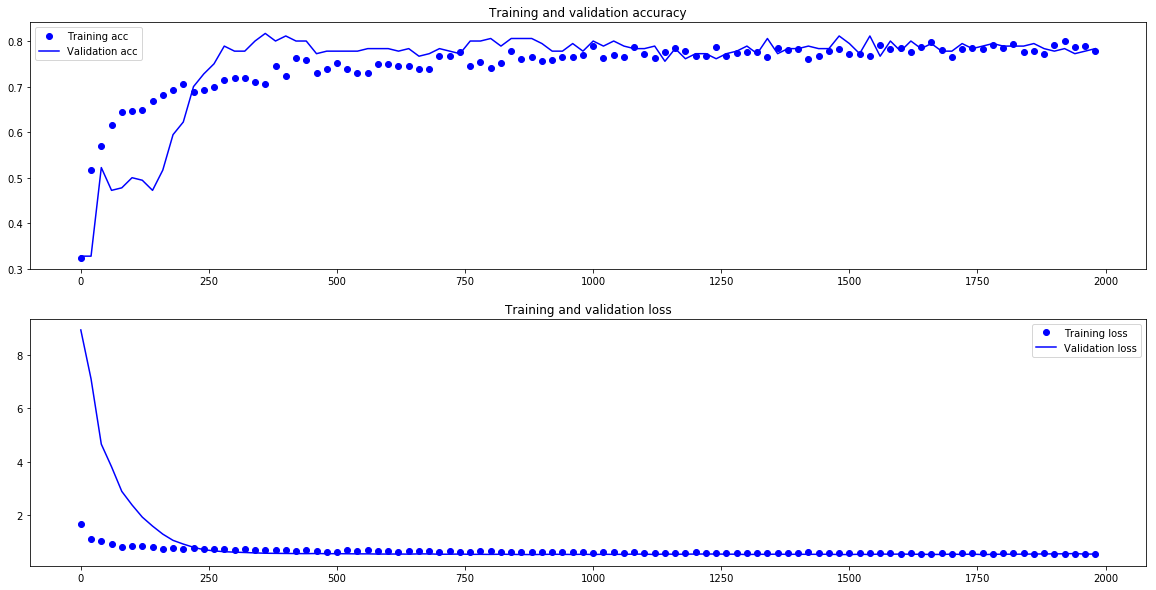

In [19]:
plot_history(history)

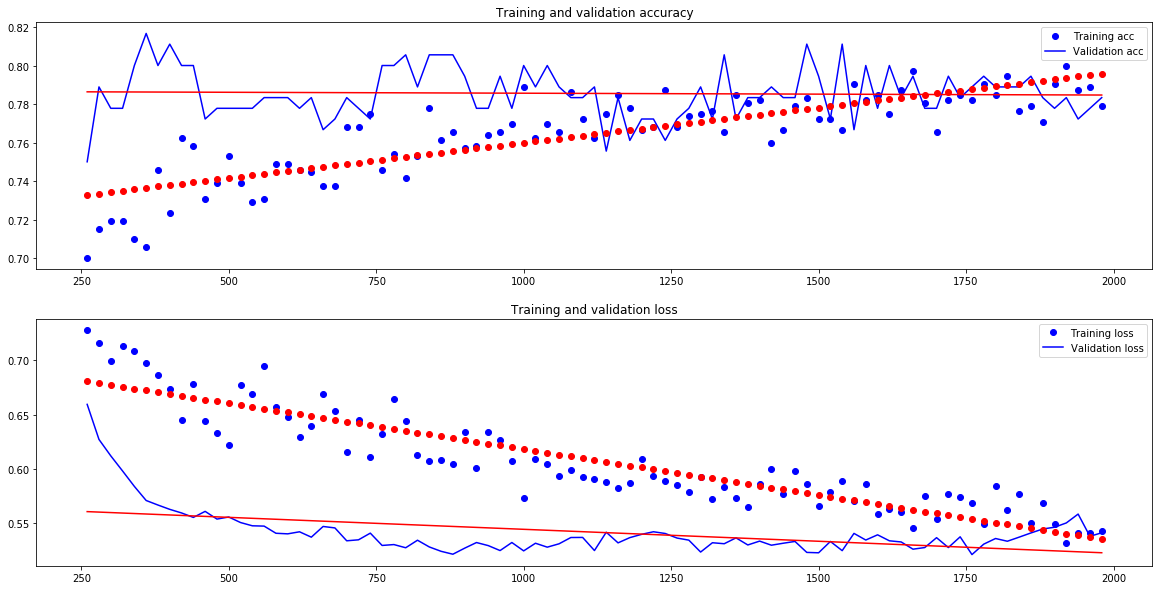

In [20]:
plot_history(history, init_phase_samples=250, plot_line=True)

### Scores around 80% look good now, there might even be a bit more potential here, but we are not going after a final percent here

## We now seem to have a decent model, so we save it for the next steps

In [21]:
model.save('insurance.hdf5')

In [22]:
# the model has a decent size as we only have a little more than 10.000 parameters
!ls -l insurance.hdf5

-rw-r--r-- 1 olive 197609 179704 Sep 10 14:33 insurance.hdf5
